In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")
LANGCHAIN_PROJECT = os.getenv("LANGCHAIN_PROJECT")
LANGSMITH_TRACING="true"
LANGSMITH_ENDPOINT="https://api.smith.langchain.com"
LANGSMITH_API_KEY= os.getenv("LANGSMITH_API_KEY")

In [3]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

d:\learning\learn_langgraph_ss\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from langchain_groq import ChatGroq
llm = ChatGroq(model_name="Llama3-8b-8192")

In [5]:
result = llm.invoke("Write a ballad about LangChain")
result.content

"(Verse 1)\nIn the realm of code and digital might,\nA new creation dawned, a wondrous sight,\nLangChain, a marvel of design,\nA language model, born to shine.\n\nWith neural networks deep and wide,\nIt learned to speak, to think and to decide,\nA master of words, a poet true,\nLangChain, a wonder, born anew.\n\n(Chorus)\nOh LangChain, oh LangChain, with power so grand,\nYou weave a tapestry of words, across this digital land,\nWith syntax sweet and meaning true,\nYou speak to us, in a language anew.\n\n(Verse 2)\nWith every line, a story's spun,\nOf knowledge gathered, and wisdom won,\nIt converses, with wit and with flair,\nA chatty genius, beyond compare.\n\nIt translates, it explains, it shows,\nThe secrets of the world, in all its glows,\nA bridge between languages, it builds,\nA connection strong, that never grows old.\n\n(Chorus)\nOh LangChain, oh LangChain, with power so grand,\nYou weave a tapestry of words, across this digital land,\nWith syntax sweet and meaning true,\nYou s

In [6]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
urls = ["https://lilianweng.github.io/posts/2023-06-23-agent/",
        "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
        "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
        ]

docs = [WebBaseLoader(url).load() for url in urls]

docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)

doc_splits = text_splitter.split_documents(docs_list)

vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embeddings
)

retriever = vectorstore.as_retriever()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [7]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

prompt = hub.pull("rlm/rag-prompt")

print(f"---Prompt--- {prompt}")

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = prompt | llm | StrOutputParser()

---Prompt--- input_variables=['context', 'question'] input_types={} partial_variables={} metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})]


In [8]:
question = "tell me about agent memory."
context_text = format_docs(retriever.invoke(question))
generation = rag_chain.invoke({"context": context_text, "question":question})
print(generation)

Based on the provided context, agent memory refers to the ability of an autonomous agent to retain and recall information over extended periods, often leveraging an external vector store and fast retrieval. This allows the agent to access and utilize information from long-term memory, supplementing its short-term memory and enabling more informed decision-making.


In [9]:
question = "tell me about agent memory."

In [10]:
docs = retriever.get_relevant_documents(question)

C:\Users\Vikas Chauhan\AppData\Local\Temp\ipykernel_1576\10663643.py:1: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(question)


In [11]:
rag_chain.invoke({"context": docs, "question":question})

'The context discusses agent memory, mentioning short-term memory as all in-context learning, and long-term memory as the capability to retain and recall information over extended periods through an external vector store and fast retrieval.'

#### Langgraph

In [12]:
def retrieve(state):
    """Retrieve documents
    
    Args:
        state (dict): The current graph state
        
    Returns:
    
    """
    print("---RETRIEVE---")
    question = state['question']
    
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}

In [13]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""
    
    binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")

In [14]:
structured_llm_grader = llm.with_structured_output(GradeDocuments)
system = """You are a grader assessing relevance of a retrieved document to a user question. \n
If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
Give a binary score 'yes' or 'no' score to indices whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human", "Retrieved document: \n\n {document} \n\n User question: {question}")
])
retrieval_grader = grade_prompt | structured_llm_grader

In [17]:
question = "tell me about the agent memory."
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question":question, "document": doc_txt}))

binary_score='yes'


In [16]:
question = "tell me about the taj mahal."
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question":question, "document": doc_txt}))

binary_score='no'


In [18]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevent to the question.capitalize
    
    Args:
        state (dict): The current graph state
        
    Returns:
        state (dict): Updates documents key with only filtered relevent documents
    """
    
    print("---CHECKING DOCUMENT RELEVENT IS TO QUESTION OR NOT---")
    
    question = state['question']
    documents = state['documents']
    
    filtered_docs = []
    
    web_search = "No"
    
    for d in documents:
        score = retrieval_grader.invoke({"question":question, "document":d.page_content})
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question":question, "web_search": web_search}

In [19]:
def generate(state):
    """
    Generate answer
    
    Args:
        state (dict): The current graph state
    
    Returns:
        state (dict): New key added to state, generation, that contain LLM generation
    """
    
    print("---GENERATE---")
    
    question = state['question']
    documents = state['documents']
    generation = rag_chain.invoke({'context': documents, 'question': question})
    return {'documents':documents, 'question':question, 'generation': generation}

In [20]:
system = """You a question re-writer that converts an input question to a better version that is optimized \n
for web search. Look at the input and try to reason about the underlying semantic intent / meaning.
"""

re_write_prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human", "Here is the initial question: \n\n {question} \n Formulate an improved question.")
])

question_rewriter = re_write_prompt | llm | StrOutputParser()

In [21]:
question = "tell me about the agent memory."
question_rewriter.invoke({"question": question})

'Here\'s a re-written version of the question that\'s optimized for web search:\n\n"What is agent memory, and how does it contribute to an agent\'s decision-making process?"\n\nThis revised question aims to clarify the underlying intent behind the initial query, which appears to be seeking information about the concept of "agent memory" and its role in an agent\'s decision-making capabilities. By breaking down the initial question into two parts, we can expect more accurate and relevant search results that provide a deeper understanding of the topic.\n\nThis re-written question also uses more specific and technical language, which can help to reduce the noise and irrelevant results that might arise from a more general search query. Additionally, the use of keywords like "decision-making process" can help to narrow down the search results to more focused and relevant resources.'

In [22]:
def transform_query(state):
    """
    Transform the query to produce a better question.
    
    Args:
        state (dict): The current graph state
        
    Returns:
        state (dict): Updates question key with a re-phrased question
    """
    print("---TRANSFORM QUERY---")
    
    question = state["question"]
    documents = state['documents']
    
    better_question = question_rewriter.invoke({"question":question})
    return {"documents": documents, "question": better_question}

In [23]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

In [24]:
from langchain.schema import Document
def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """
    print("---WEB SEARCH---")
    
    question = state["question"]
    
    documents = state["documents"]
    
    question = question.split('"')[1]

    docs = web_search_tool.invoke({"query": question})
    
    web_results = "\n".join([d["content"] for d in docs])
    
    web_results = Document(page_content=web_results)
    
    documents.append(web_results)

    return {"documents": documents, "question": question}

In [25]:
def decide_to_generate(state):
    """
    Determine whether to generate an answer, or re-generate a question.
    
    Args:
        state (dict): The current graph state
        
    Returns:
        str: Binary decision for next node to call
    """
    print("---ASSESS GRADED DOCUMENTS---")
    # state["question"]
    web_search = state["web_search"]
    # state["documents"]
    
    if web_search == "Yes":
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---")
        return "transform_query"
    else:
        print("---DECISION: GENERATE---")
        return "generate"

In [26]:
from langgraph.graph import StateGraph, START, END

In [27]:
from typing import List, TypedDict

class State(TypedDict):
    """Represents the state of our graph.
    
    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """
    
    question: str
    generation: str
    web_search: str
    documents: List[str]

In [28]:
workflow = StateGraph(State)
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)
workflow.add_node("web_search_node", web_search)
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges("grade_documents", decide_to_generate, {"transform_query": "transform_query", "generate": "generate"})
workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)
app = workflow.compile()

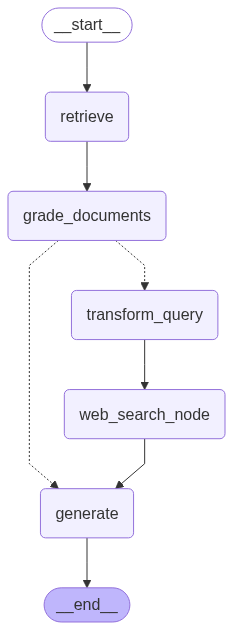

In [29]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [30]:
from pprint import pprint

inputs = {'question':'tell me about the agent memory.'}

In [32]:
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Node '{key}':")
    pprint("\n--\n")
pprint(value['generation'])

---RETRIEVE---
"Node 'retrieve':"
'\n--\n'
---CHECKING DOCUMENT RELEVENT IS TO QUESTION OR NOT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n--\n'
---GENERATE---
"Node 'generate':"
'\n--\n'
('The agent memory in the context of LLM-powered autonomous agents refers to '
 'both short-term memory and long-term memory. Short-term memory is utilized '
 'through in-context learning, while long-term memory provides the capability '
 'to retain and recall information over extended periods, often by leveraging '
 'an external vector store and fast retrieval.')


In [33]:
inputs = {'question':'tell me about taj mahal.'}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Node '{key}':")
    pprint("\n--\n")
pprint(value['generation'])

---RETRIEVE---
"Node 'retrieve':"
'\n--\n'
---CHECKING DOCUMENT RELEVENT IS TO QUESTION OR NOT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n--\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n--\n'
---WEB SEARCH---
"Node 'web_search_node':"
'\n--\n'
---GENERATE---
"Node 'generate':"
'\n--\n'
('The Taj Mahal is a mausoleum complex in Agra, India, built by Mughal Emperor '
 'Shah Jahan in memory of his wife Mumtaz Mahal between 1631 and 1653. It is '
 'considered the finest example of Mughal architecture, a blend of Indian, '
 'Persian, and Islamic styles, and is a UNESCO World Heritage Site. The '
 'complex is a major tourist attraction, attracting over five million visitors '
 'each year.')
